In [17]:
import rebound as rb
import reboundx
from reboundx import constants as rbx_constants
import numpy as np
from celmech.miscellaneous import frequency_modified_fourier_transform as fmft
from test_particle_secular_hamiltonian import SyntheticSecularTheory
import celmech as cm
import sys
import pandas as pd
sys.path.insert(0, "..")
from matplotlib import pyplot as plt

In [2]:
# used for getting fmft result closest to target frequency
def closest_key_entry(d, target):
    """
    Given a dictionary `d` with float keys and a target float `target`,
    returns a tuple (key, value) where the key is the one in `d`
    closest to `target`.

    Parameters
    ----------
    d : dict
        Dictionary with float keys.
    target : float
        The float to compare keys against.

    Returns
    -------
    tuple
        The (key, value) pair whose key is closest to `target`.
    """
    closest_key = min(d.keys(), key=lambda k: abs(k - target))
    return closest_key, d[closest_key]


# Outer solar system synthetic secular theory
This notebook uses a numerical integration and the frequency modified Fourier transform to generate a synthetic secular theory for the outer solar system planets.

# Units are Msun, AU and yr/2pi with G = 1

In [3]:
start_time = 2460200.5 # Nesvorny epoch

try:
    sim = rb.Simulation('outer_solar_system.bin')
except:
    from utils import ecliptic_to_icrf, icrf_to_ecliptic, ecliptic_xyz_to_elements
    import assist
    ephem = assist.Ephem("../../assist/data/linux_m13000p17000.441", "data/assist/data/sb441-n16.bsp")
    t0 = start_time - ephem.jd_ref # Code units will be Julian days relative to jd_reftimes
    bodies = ("Sun", "Jupiter","Saturn","Uranus","Neptune")
    conver = 58.132440867049
    Msun = ephem.get_particle('Sun', t0).m

    sim = rb.Simulation()
    for body in bodies:
        p = ephem.get_particle(body, t0)
        p = icrf_to_ecliptic(p)
        p.vxyz = np.array(p.vxyz) * conver
        sim.add(m=p.m/Msun, x=p.x, y=p.y, z=p.z, vx=p.vx, vy=p.vy, vz=p.vz)
    sim.move_to_com()
    sim.save_to_file('outer_solar_system.bin')

# Quick cross-check that we have things at the right epoch, comparing assist setup to Horizons query

In [4]:
orbit = sim.particles[1].orbit(primary=sim.particles[0])
sim2 = rb.Simulation()
sim2.add('Sun', date='JD{0}'.format(start_time))
sim2.add('Jupiter', date='JD{0}'.format(start_time))
orbit2 = sim2.particles[1].orbit(primary=sim2.particles[0])

print(orbit.f, orbit2.f)

Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
0.3758166079278684 0.37581660789009774


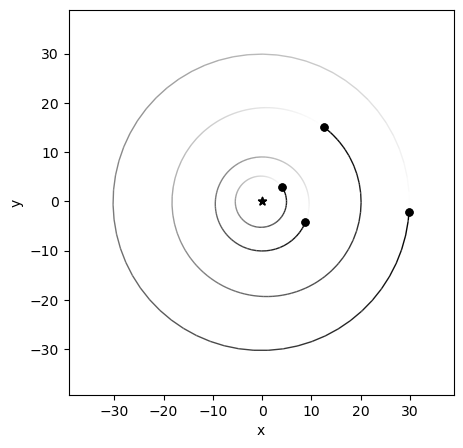

In [5]:
rb.OrbitPlot(sim)

In [6]:
%%time
rebx = reboundx.Extras(sim)
gr = rebx.load_force("gr")
rebx.add_force(gr)
gr.params['c'] = rbx_constants.C

#cm.nbody_simulation_utilities.align_simulation(sim)
try: 
    results = cm.nbody_simulation_utilities.get_simarchive_integration_results("outer_solar_system.sa",coordinates='heliocentric')
except:
    sim.integrator = 'whfast'
    sim.dt = sim.particles[1].P / 25.
    sim.ri_whfast.safe_mode = 0
    Tfin_approx = 1e7 * 2*np.pi
    total_steps = np.ceil(Tfin_approx / sim.dt)
    Tfin = total_steps * sim.dt + sim.dt
    Nout = 8192
    sim.save_to_file("outer_solar_system.sa",step=int(np.floor(total_steps/Nout)),delete_file=True)
    sim.integrate(Tfin,exact_finish_time=0)
    results = cm.nbody_simulation_utilities.get_simarchive_integration_results("outer_solar_system.sa",coordinates='heliocentric')

/Users/dtamayo/Documents/workspace/rebound/rebound/simulationarchive.py:150: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/dtamayo/Documents/workspace/rebound/rebound/simulationarchive.py:155: RuntimeWarning: The simulation might not be synchronized. You can manually synchronize it by calling sim.synchronize().
  warnings.warn("The simulation might not be synchronized. You can manually synchronize it by calling sim.synchronize().", RuntimeWarning)


CPU times: user 33 s, sys: 4.75 s, total: 37.7 s
Wall time: 1min


In [7]:
results['X'] = np.sqrt(2*(1-np.sqrt(1-results['e']**2))) * np.exp(1j * results['pomega'])
results['Y'] = (1-results['e']**2)**(0.25) * np.sin(0.5 * results['inc'] )* np.exp(1j * results['Omega'])

In [8]:
planets = ("Jupiter","Saturn","Uranus","Neptune")
ecc_fmft_results = dict()
inc_fmft_results = dict()
for i,pl in enumerate(planets):
    ecc_fmft_results[pl] = fmft(results['time'],results['X'][i],14)
    planet_e_freqs = np.array(list(ecc_fmft_results[pl].keys()))
    planet_e_freqs_arcsec_per_yr = planet_e_freqs * 60*60*180/np.pi * (2*np.pi)

    inc_fmft_results[pl] = fmft(results['time'],results['Y'][i],8)
    planet_inc_freqs = np.array(list(inc_fmft_results[pl].keys()))
    planet_inc_freqs_arcsec_per_yr = planet_inc_freqs * 60*60*180/np.pi * (2*np.pi)

    print("")
    print(pl)
    print("g\t\t Abs\t\t Real\t\t Imag")
    print("-------")
    for g in planet_e_freqs[:6]:
        print("{:+07.3f} \t {:0.6f} \t {num.real:0.6f} \t {num.imag:0.6f}".format(g * 60 * 60 * 180 / np.pi * (2 * np.pi), np.abs(ecc_fmft_results[pl][g]), num=ecc_fmft_results[pl][g]))
    print("\ns\t\t Abs\t\t Real\t\t Imag")
    print("-------")
    for g in planet_inc_freqs[:4]:
        print("{:+07.3f} \t {:0.6f} \t {num.real:0.6f} \t {num.imag:0.6f}".format(g * 60 * 60 * 180 / np.pi * (2 * np.pi), np.abs(inc_fmft_results[pl][g]), num=inc_fmft_results[pl][g]))


Jupiter
g		 Abs		 Real		 Imag
-------
+04.246 	 0.044206 	 0.037496 	 0.023413
+28.241 	 0.015694 	 0.011514 	 -0.010666
+03.089 	 0.001843 	 -0.000950 	 0.001579
-30.978 	 0.000642 	 0.000477 	 -0.000430
+52.237 	 0.000571 	 0.000263 	 0.000507
+464.193 	 0.000396 	 0.000320 	 -0.000234

s		 Abs		 Real		 Imag
-------
+00.000 	 0.013772 	 -0.004171 	 0.013125
-26.338 	 0.003150 	 0.001488 	 -0.002777
-00.692 	 0.000574 	 0.000522 	 0.000239
-02.994 	 0.000485 	 -0.000371 	 0.000312

Saturn
g		 Abs		 Real		 Imag
-------
+28.241 	 0.048225 	 -0.035379 	 0.032772
+04.246 	 0.032965 	 0.027961 	 0.017461
+52.237 	 0.001925 	 -0.000886 	 -0.001709
+03.089 	 0.001533 	 -0.000791 	 0.001314
+345.753 	 0.001510 	 -0.001211 	 0.000902
+464.193 	 0.001246 	 -0.001005 	 0.000737

s		 Abs		 Real		 Imag
-------
+00.000 	 0.013767 	 -0.004170 	 0.013120
-26.338 	 0.007853 	 -0.003708 	 0.006922
-00.692 	 0.000553 	 0.000503 	 0.000230
-02.994 	 0.000394 	 -0.000301 	 0.000253

Uranus
g		 Abs		 Real

In [ ]:
np.complex128(0.025367303061632655+0.015839808557265817j),
np.complex128(0.013055589585200455-0.012094065831797262j),
np.complex128(-0.000631906677364072+0.0010499556899770824j),
np.complex128(-8.651800059783336e-05-0.00016687557685614304j),
np.complex128(4.079837191229496e-08+1.4957049278466673e-07j)

(0.0, 10000000.0)

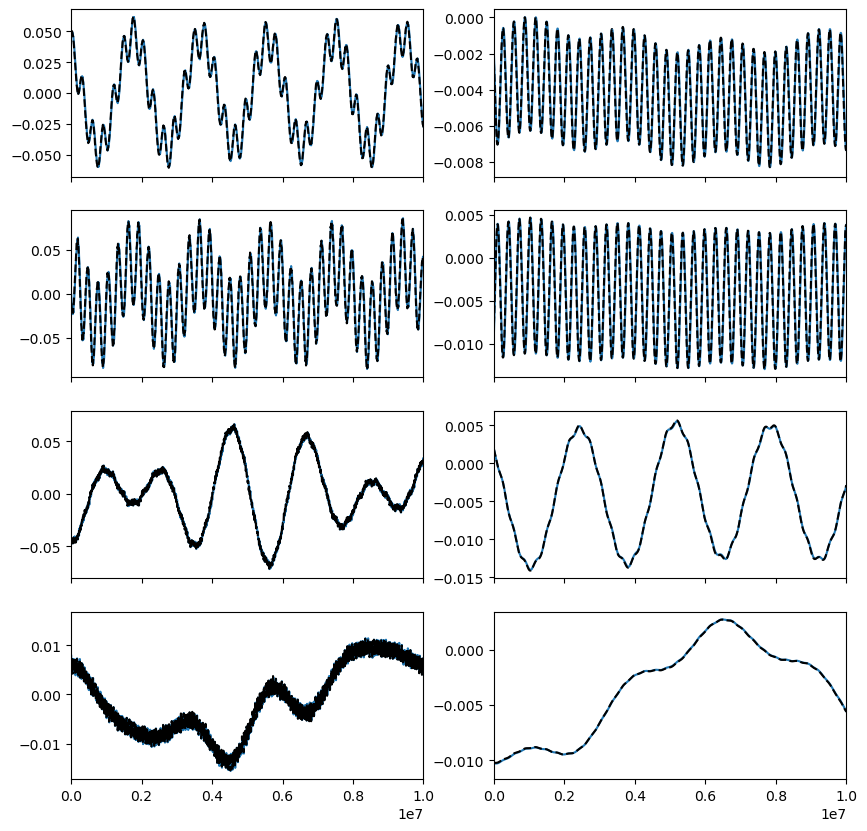

In [9]:
fig,ax = plt.subplots(sim.N-1,2,sharex=True,figsize=(10,10))
Xsolns = []
Ysolns = []
for i,pl in enumerate(planets):
    freq_amp_dict = ecc_fmft_results[pl]
    ax[i,0].plot(results['time'],np.real(results['X'][i]))
    zsoln = np.sum([amp * np.exp(1j*freq*results['time']) for freq,amp in freq_amp_dict.items()],axis=0)
    ax[i,0].plot(results['time'],np.real(zsoln),'k--')

    freq_amp_dict = inc_fmft_results[pl]
    Ysolns.append(freq_amp_dict)
    ax[i,1].plot(results['time'],np.real(results['Y'][i]))
    zsoln = np.sum([amp * np.exp(1j*freq*results['time']) for freq,amp in freq_amp_dict.items()],axis=0)
    ax[i,1].plot(results['time'],np.real(zsoln),'k--')
plt.xlim(0,1e7)

In [10]:
ARCSEC_PER_YR = 1/(180*60*60*2)
g_vec = np.zeros(4)
s_vec = np.zeros(3)

g_vec[:3] = np.array(list(ecc_fmft_results['Jupiter'].keys()))[:3]
g_vec[3] = list(ecc_fmft_results['Neptune'].keys())[0]
s_vec[0] = list(inc_fmft_results['Jupiter'].keys())[0]
s_vec[1] = list(inc_fmft_results['Jupiter'].keys())[2]
s_vec[2] = list(inc_fmft_results['Jupiter'].keys())[1]
omega_vec = np.concatenate((g_vec,s_vec))
g_and_s_arc_sec_per_yr = omega_vec / ARCSEC_PER_YR
g_and_s_arc_sec_per_yr

array([ 4.24552786e+00,  2.82413604e+01,  3.08906589e+00,  6.72721651e-01,
        2.96080725e-07, -6.92438242e-01, -2.63376111e+01])

In [11]:
eye_N = np.eye(omega_vec.size,dtype = int)
x_dicts = []
for pl in planets:
    print(pl)    
    print("-"*len(pl))
    print("kvec \t\t\t omega \t err. \t amplitude")
    x_dict = {}
    for i,omega_i in enumerate(omega_vec[:4]):
        omega_N,amp = closest_key_entry(ecc_fmft_results[pl],omega_vec[i])
        omega_error = np.abs(omega_N/omega_i-1)
        if omega_error<0.001:
            print (eye_N[i],"\t{:+07.3f}\t{:.1g} \t{:.1g}".format(omega_i/ARCSEC_PER_YR,omega_error,np.abs(amp)))
            x_dict[tuple(eye_N[i])] = amp
    #NL terms
    for a in range(7):
        for b in range(a,7):
            for c in range(7):
                if c==a:
                    continue
                if c==b:
                    continue
                k = np.zeros(7,dtype = int)
                k[a] +=1
                k[b] +=1
                k[c] -=1
                omega=k@omega_vec
                omega_N,amp = closest_key_entry(ecc_fmft_results[pl],omega)
                omega_error = np.abs(omega_N/omega-1)
                if omega_error<0.001:
                    print (k,"\t{:+07.3f}\t{:.1g},\t{:.1g}".format(omega/ARCSEC_PER_YR,omega_error,np.abs(amp)))
                    x_dict[tuple(k)] = amp
    x_dicts.append(x_dict)

Jupiter
-------
kvec 			 omega 	 err. 	 amplitude
[1 0 0 0 0 0 0] 	+04.246	0 	0.04
[0 1 0 0 0 0 0] 	+28.241	0 	0.02
[0 0 1 0 0 0 0] 	+03.089	0 	0.002
[ 1  1 -1  0  0  0  0] 	+29.398	2e-07,	0.0002
[-1  2  0  0  0  0  0] 	+52.237	2e-06,	0.0006
[-1  1  1  0  0  0  0] 	+27.085	3e-06,	0.0002
[ 0  1  0  1 -1  0  0] 	+28.914	0.0008,	0.0001
[ 0  1  0 -1  1  0  0] 	+27.569	0.0009,	0.0001
[ 0  0  1  0  1  0 -1] 	+29.427	0.001,	0.0002
Saturn
------
kvec 			 omega 	 err. 	 amplitude
[1 0 0 0 0 0 0] 	+04.246	4e-07 	0.03
[0 1 0 0 0 0 0] 	+28.241	2e-08 	0.05
[0 0 1 0 0 0 0] 	+03.089	9e-09 	0.002
[ 1  1 -1  0  0  0  0] 	+29.398	8e-08,	0.0006
[-1  2  0  0  0  0  0] 	+52.237	3e-06,	0.002
[-1  1  1  0  0  0  0] 	+27.085	2e-06,	0.0006
[ 0  1  0  1 -1  0  0] 	+28.914	0.0008,	0.0004
[ 0  1  0 -1  1  0  0] 	+27.569	0.0009,	0.0003
[ 0  0  1  0  1  0 -1] 	+29.427	0.001,	0.0006
Uranus
------
kvec 			 omega 	 err. 	 amplitude
[1 0 0 0 0 0 0] 	+04.246	3e-08 	0.04
[0 1 0 0 0 0 0] 	+28.241	1e-07 	0.002
[0 0 1 0 0 0

In [12]:
y_dicts = []
for pl in planets:
    print(pl)    
    print("-"*len(pl))
    print("kvec \t\t\t omega \t err. \t amplitude")
    y_dict = {}
    for i,omega_i in enumerate(omega_vec[4:]):
        omega_N,amp = closest_key_entry(inc_fmft_results[pl],omega_vec[4+i])
        omega_error = np.abs(omega_N/omega_i-1)
        if omega_error<0.001:
            print (eye_N[4+i],"\t{:+07.3f}\t{:.1g} \t{:.1g}".format(omega_i/ARCSEC_PER_YR,omega_error,np.abs(amp)))
            y_dict[tuple(eye_N[4+i])] = amp
    #NL terms
    for a in range(7):
        for b in range(a,7):
            for c in range(7):
                if c==a:
                    continue
                if c==b:
                    continue
                k = np.zeros(7,dtype = int)
                k[a] +=1
                k[b] +=1
                k[c] -=1
                omega=k@omega_vec
                omega_N,amp = closest_key_entry(inc_fmft_results[pl],omega)
                omega_error = np.abs(omega_N/omega-1)
                if omega_error<0.001:
                    print (k,"\t{:+07.3f}\t{:.1g} \t{:.1g}".format(omega/ARCSEC_PER_YR,omega_error,np.abs(amp)))
                    y_dict[tuple(k)] = amp
    y_dicts.append(y_dict)

Jupiter
-------
kvec 			 omega 	 err. 	 amplitude
[0 0 0 0 1 0 0] 	+00.000	0 	0.01
[0 0 0 0 0 1 0] 	-00.692	0 	0.0006
[0 0 0 0 0 0 1] 	-26.338	0 	0.003
[ 0  2  0  0  0  0 -1] 	+82.820	2e-08 	1e-05
[-1  1  0  0  0  0  1] 	-02.342	0.0004 	2e-05
[ 0  0  0 -1  1  0  1] 	-27.010	0.0008 	2e-05
Saturn
------
kvec 			 omega 	 err. 	 amplitude
[0 0 0 0 0 1 0] 	-00.692	9e-06 	0.0006
[0 0 0 0 0 0 1] 	-26.338	1e-09 	0.008
[ 1  1  0  0  0  0 -1] 	+58.824	9e-08 	2e-05
[ 0  2  0  0  0  0 -1] 	+82.820	2e-08 	4e-05
[ 0  0  0 -1  1  0  1] 	-27.010	0.0008 	6e-05
Uranus
------
kvec 			 omega 	 err. 	 amplitude
[0 0 0 0 0 1 0] 	-00.692	0.0005 	0.0006
[0 0 0 0 0 0 1] 	-26.338	8e-08 	0.0004
[-1  1  0  0  0  0  1] 	-02.342	6e-05 	0.0003
[ 0  1 -1  0  0  0  1] 	-01.185	0.0008 	3e-05
Neptune
-------
kvec 			 omega 	 err. 	 amplitude
[0 0 0 0 0 1 0] 	-00.692	0.0004 	0.006
[0 0 0 0 0 0 1] 	-26.338	3e-08 	4e-05
[-1  1  0  0  0  0  1] 	-02.342	0.0002 	6e-05


In [13]:
solar_system_synthetic_theory = SyntheticSecularTheory(
    [p.m for p in sim.particles[1:]],
    [np.mean(a) for a in results['a']],
    omega_vec,
    x_dicts,
    y_dicts
)

In [14]:
import pickle
with open("solar_system_synthetic_solution.bin","wb") as fi:
    pickle.dump(solar_system_synthetic_theory,fi)


In [15]:
def linear_theory_prediction(e, inc, omega, Omega, propa, simpler_secular_theory):
    X = np.sqrt(2*(1-np.sqrt(1-e**2))) * np.exp(1j * omega)
    Y = 2*(1-e**2)**(0.25) * np.sin(0.5 * inc) * np.exp(1j * Omega)
    tp_h = TestParticleSecularHamiltonian(propa, simpler_secular_theory)

    u0 = X - np.sum(list(tp_h.F_e.values()))
    v0 = Y - np.sum(list(tp_h.F_inc.values()))
    g0, s0 = calc_g0_and_s0(propa, simpler_secular_theory)

    return u0, v0, g0, s0

In [32]:
from linear_theory import linear_theory_prediction, make_simpler_secular_theory
simpler_secular_theory = make_simpler_secular_theory()

try:
    nesvorny_df = pd.read_csv("../data/nesvorny_catalog_dataset_small.csv", index_col=0)
except:
    df = pd.read_fwf('../data/MPCORB.DAT', colspecs=[[0,7], [8,14], [15,19], [20,25], [26,35], [36,46], [47, 57], [58,68], [69,81], [82, 91], [92, 103]])
    df = df[df['Epoch'] == 'K239D'] # take only ones at common epoch--almost all of them
    for c in ['a', 'e', 'Incl.', 'Node', 'Peri.', 'M']:
    	df[c] = pd.to_numeric(df[c])
    
    labels = pd.read_fwf('../data/proper_catalog24.dat', colspecs=[[0,10], [10,18], [19,28], [29,37], [38, 46], [47,55], [56,66], [67,78], [79,85], [86, 89], [90, 97]], header=None, index_col=False, names=['propa', 'da', 'prope', 'de', 'propsini', 'dsini', 'g', 's', 'H', 'NumOpps', "Des'n"])

    nesvorny_df = pd.merge(df, labels, on="Des'n", how="inner")
    nesvorny_df.head(1000).to_csv("../data/nesvorny_catalog_dataset_small.csv")

# Would have guessed these would match up better (for eccentricities)

In [35]:
row = nesvorny_df.iloc[0]
u0, v0, g0, s0 = linear_theory_prediction(row['e'], row['Incl.'] * np.pi / 180, row['Peri.'] * np.pi / 180, row['Node'] * np.pi / 180, row['propa'], simpler_secular_theory)
print(row['prope'], np.abs(u0))
print(row['propsini'], np.sin(np.abs(v0)))

0.115193 0.07266378868234838
0.16756 0.16790572626778327


In [36]:
Nout = 1000
e, sini, prope, propsini, lineare, linearsini = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
for i in range(Nout):
    row = nesvorny_df.iloc[i]
    u0, v0, g0, s0 = linear_theory_prediction(row['e'], row['Incl.'] * np.pi / 180, row['Peri.'] * np.pi / 180, row['Node'] * np.pi / 180, row['propa'], simpler_secular_theory)
    e[i] = row['e']
    prope[i] = row['prope']
    lineare[i] = np.abs(u0)
    sini[i] = np.sin(row['Incl.']*np.pi/180)
    propsini[i] = row['propsini']
    linearsini[i] = np.sin(np.abs(v0))

# Proper e vs osculating e is a tighter correlation (slightly)

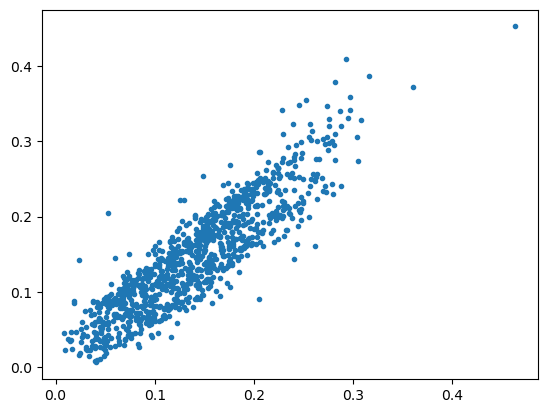

In [39]:
fig, ax = plt.subplots()
ax.plot(prope, e, '.')

# than linear e prediction vs proper e

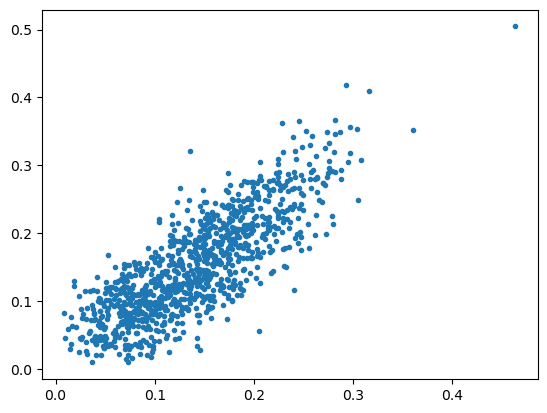

In [110]:
fig, ax = plt.subplots()
ax.plot(prope, lineare, '.')

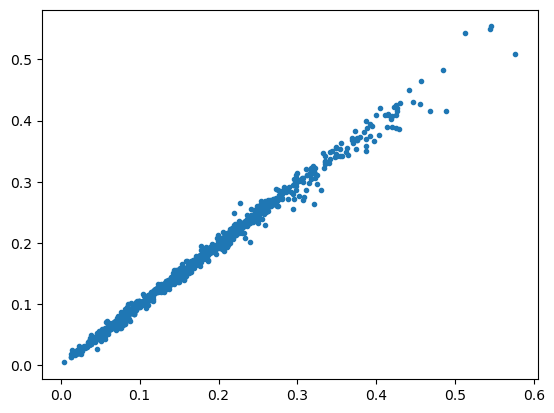

In [106]:
fig, ax = plt.subplots()
ax.plot(sini, propsini, '.')